In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
import pylightcurve as plc
from IPython.display import display, Math
from astropy import constants as const
from astropy import units as u
%matplotlib inline

    Done!
Checking exotethys database...
Checking ephemerides database...
Checking photometry database...
Checking catalogues database...


## Transits

In [2]:
tr_data = astropy.io.ascii.read("UID_0098505_PLC_025.tbl.txt", delimiter='|')   ## Extracting transit data from Winn et al. 2007

In [3]:
print(tr_data)   ## Testing to see if data is correctly extracted

     HJD      Relative_Flux Relative_Flux_Uncertainty Accepted
     days                                                     
------------- ------------- ------------------------- --------
2453988.70219        1.0034                    0.0017        1
2453988.70235        1.0055                    0.0017        1
2453988.70251         1.003                    0.0017        1
2453988.70267        0.9995                    0.0017        1
2453988.70285        0.9969                    0.0017        1
2453988.70301        0.9995                    0.0017        1
2453988.70337        1.0034                    0.0017        1
2453988.70353        1.0033                    0.0017        1
2453988.70369        0.9995                    0.0017        1
2453988.70385        0.9986                    0.0017        1
          ...           ...                       ...      ...
2453988.85926        1.0015                    0.0037        1
2453988.85944         1.004                    0.0037  

In [4]:
planet = plc.get_planet('hd189733b')     ## Changes from Dr. Wang's code. Extract all data for the planet

time_array = tr_data["HJD"].data

# Calculate Limb-darkening parameters
limb_darkening_coefficients = planet.filter('COUSINS_R').limb_darkening_coefficients   ## Also changed from Dr. Wang's code (source: https://github.com/ucl-exoplanets/pylightcurve/blob/master/README.md)

# Calculate transiting light curve
flux_array = planet.transit_integrated(time_array, time_format='BJD_TDB', exp_time=120, time_stamp = 'mid', filter_name='COUSINS_R', max_sub_exp_time=1)

PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.


In [5]:
print(limb_darkening_coefficients)   ## Checking Limb Darkening coeffs

[0.5226569509505041, -0.1711311572908598, 0.7484846982545578, -0.318073680544776]


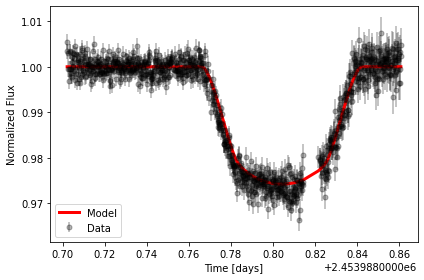

In [6]:
plt.errorbar(tr_data["HJD"], tr_data["Relative_Flux"], tr_data["Relative_Flux_Uncertainty"], ms=5, \
             marker="o", ls="none", label="Data", color="black", alpha=0.3)

# flx = 2.512**(-tr_data["col2"])
# flx = flx / np.median(flx)
# plt.plot(tr_data["col1"], flx , ms=5, \
#              marker="o", ls="none", label="Data", color="black", alpha=0.3)

plt.plot(time_array, flux_array, 'r-', lw=3, label="Model")
plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.xlabel('Time [days]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.tight_layout()

In [7]:
delta = 1 - np.mean(tr_data["Relative_Flux"].data[460:720:])
print(f"$\delta$ =", delta )

$\delta$ = 0.02432038461538466


In [8]:
## Finding the rough estimates of the start and stop times of the transit depth

print(tr_data["HJD"].data[460])
print(tr_data["HJD"].data[720])
print(tr_data["Relative_Flux"].data[460])
print(tr_data["Relative_Flux"].data[720])

2453988.77937
2453988.82954
0.9821
0.9775


In [9]:
delta_d = np.std(tr_data["Relative_Flux"].data[460:720:])
print(delta_d)

0.003620700081868177


## Error propogation

$\delta = (\frac{R_{p}}{R_{*}})^{2}$

$\frac{\Delta \delta}{\delta} = 2\times \frac{\Delta R_{p}}{R_{p}} + 2\times \frac{\Delta R_{*}}{R_{*}}$

In [10]:
R_star = 0.7827 * const.R_sun           ## Radius of Star from Rosenthal et al. 2021
R_planet = (delta ** (1/2)) * R_star / const.R_jup    ## Radius of planet in terms of Jupiter Radius
delta_r_star = 0.013                     ## Uncertainty taken from Rosenthat et al. 2021


delta_r_p = R_planet * (delta_d/delta * .5 - delta_r_star/0.7827)

In [11]:
print("{:.4f}".format(R_star), "m") 
print("{:.3f}".format(R_planet), "R_jup")    ## Planet radius in terms of Jupiter Radius
print("{:.3f}".format(delta_r_p), "R_jup")   ## Uncertainty in planet radius

544524390.0000 m m
1.188 R_jup
0.069 R_jup


Officially reported Radius and uncertainty is: 1.13 +/- 0.01 (Stassun et al. 2017)

## Mass

In [12]:
M_planet_calc = 1.12445      ## From Logan's data
delta_M_p = 0.015973

R_estimate = M_planet_calc ** (-0.04)      ## Using estimate given by R ~ M ^ (-0.04) relatin in the slides  
R_estimate_err = R_estimate * 0.04 * delta_M_p / M_planet_calc    ## Error Propogation

In [13]:
print("Radius estimate from slides formula =","{:.4f}".format(R_estimate), "R_jup")     ## Different from what we got and what the official is
print("Error =","{:.4f}".format(R_estimate_err), "R_jup")

Radius estimate from slides formula = 0.9953 R_jup
Error = 0.0006 R_jup


## Density 

In [15]:
rho_planet = M_planet_calc * const.M_jup / (4 / 3 * np.pi * (R_planet * const.R_jup) ** 3)
delta_rho_p = rho_planet * (delta_M_p / M_planet_calc + 3 * delta_r_p / R_planet)

print("Calculated Density =","{:.4f}".format(rho_planet), "+/-","{:.4f}".format(delta_rho_p))

Calculated Density = 832.0867 kg / m3 +/- 156.1746 kg / m3


Officially reported density = 943 (+ 81, - 72) kg / m^3  (Bonomo et al. 2017)

In [16]:
tab = astropy.io.ascii.read("PS_2022.01.24_09.54.25.csv")
print(tab.colnames)

['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim', 'st_metratio', 'st_logg', 'st

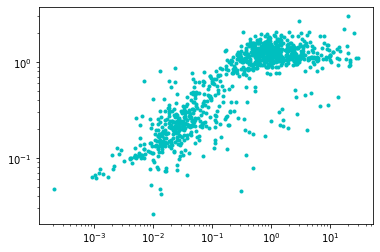

In [17]:
plt.plot(tab["pl_bmassj"], tab["pl_radj"],'.c')
plt.xscale("log")
plt.yscale("log")

In [21]:
pl_density = [x * (const.M_jup / u.kg) / (4/3 * np.pi * ((y * (const.R_jup / u.m))) ** 3) for x,y in zip (tab["pl_bmassj"], tab["pl_radj"])]
print(len(pl_density))
print(len(tab["pl_bmassj"]))
print(len(tab["pl_radj"]))

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


4903
4903
4903


/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


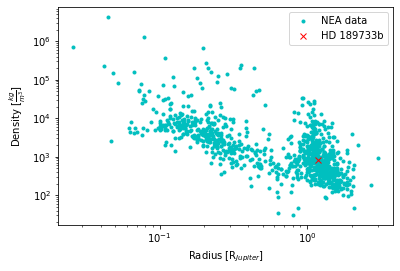

In [32]:
plt.plot(tab["pl_radj"], pl_density, '.c', label = "NEA data")
plt.xscale("log")
plt.yscale("log")
plt.plot(R_planet, rho_planet, 'xr', label = "HD 189733b")
plt.ylabel(r"Density [$\frac{kg}{m^{3}}$]")
plt.xlabel(r"Radius [R$_{Jupiter}$]")
plt.legend(loc = 0)

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


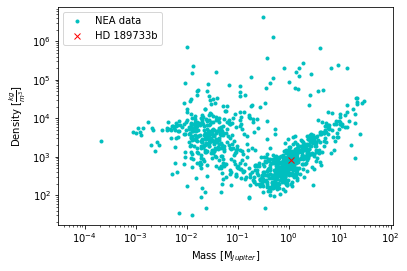

In [30]:
plt.plot(tab["pl_bmassj"], pl_density, '.c', label = "NEA data")
plt.xscale("log")
plt.yscale("log")
plt.plot(M_planet_calc, rho_planet, 'xr', label = "HD 189733b")
plt.ylabel(r"Density [$\frac{kg}{m^{3}}$]")
plt.xlabel(r"Mass [M$_{Jupiter}$]")
plt.legend(loc = 2)